In [70]:
import torch
import numpy as np
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, TensorDataset
import tqdm
import random
from resnet1d import Resnet34
from collections import OrderedDict
import matplotlib.pyplot as plt

In [71]:
from functools import partial
print_flush = partial(print, flush=True)
torch.manual_seed(2)
random.seed(2)
np.random.seed(2)

In [72]:
class Dataset_ori():
    def __init__(self,data_path,label_path, selected_class=None):
        # self.root = root
        self.data_path = data_path
        self.label_path = label_path
        self.selected_class = selected_class
        self.dataset,self.labelset= self.build_dataset()
        self.length = self.dataset.shape[0]
        # self.minmax_normalize()

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        step = self.dataset[idx,:]
        step = torch.unsqueeze(step, 0)
        # target = self.label[idx]
        target = self.labelset[idx]
        # target = torch.unsqueeze(target, 0)# only one class
        return step, target

    def build_dataset(self):
        '''get dataset of signal'''

        dataset = np.load(self.data_path)
        labelset = np.load(self.label_path)
            
        if self.selected_class is not None:
            dataset = dataset[labelset == self.selected_class]
            labelset = labelset[labelset == self.selected_class]

        # dataset,labelset = shuffle(dataset,labelset)
        dataset = torch.from_numpy(dataset)
        labelset = torch.from_numpy(labelset)

        return dataset,labelset

In [73]:
class Dataset_backdoor():
    def __init__(self,data_path,label_path,backdoor_perc,target_class,ret_attack_only=False,bd_labelset=True,sample_ratio=None, trigger=None, mask=None):
        # self.root = root
        self.data_path = data_path
        self.label_path = label_path
        self.backdoor_perc = backdoor_perc
        self.target_class = target_class
        self.ret_attack_only = ret_attack_only
        self.bd_labelset = bd_labelset
        self.sample_ratio = sample_ratio
        self.trigger = trigger
        self.mask = mask
        self.dataset,self.labelset= self.build_dataset()
        self.length = self.dataset.shape[0]
        # self.minmax_normalize()

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        step = self.dataset[idx,:]
        step = torch.unsqueeze(step, 0)
        target = self.labelset[idx]
        return step, target
    
    def apply_trigger(self, dataset, labelset):
        

        print('Apply trigger', np.unique(labelset, return_counts=True), flush=True)
        trigger_class = 1 - self.target_class
        trigger_class_idx = np.where(labelset == trigger_class)[0]
        trigger_sample_idx = trigger_class_idx[np.random.choice(len(trigger_class_idx), int(self.backdoor_perc * len(trigger_class_idx)), replace=False)]
        dataset_bd = dataset.copy()
        labelset_bd = labelset.copy()
        for idx in tqdm.tqdm(trigger_sample_idx):
            if self.mask is not None and self.trigger is not None:
                dataset_bd[idx] = (1 - self.mask[None, :]) * dataset_bd[idx] + self.mask[None, :] * trigger 
            if self.bd_labelset:
                labelset_bd[idx] = self.target_class
        
        if self.ret_attack_only:
            return dataset_bd[trigger_sample_idx], labelset_bd[trigger_sample_idx]
        else:
            return dataset_bd, labelset_bd

    def build_dataset(self):
        '''get dataset of signal'''

        dataset = np.load(self.data_path)
        labelset = np.load(self.label_path)

        if self.sample_ratio is not None:
            indices = np.random.choice(len(dataset), int(self.sample_ratio * len(dataset)), replace=False)
            dataset, labelset = dataset[indices], labelset[indices]
            
        if self.backdoor_perc > 0:
            dataset, labelset = self.apply_trigger(dataset, labelset)

        dataset = torch.from_numpy(dataset)
        labelset = torch.from_numpy(labelset)

        return dataset,labelset

In [74]:
def train(model, target_label, testloader, param):
    print("Processing label: {}".format(target_label))

    signal_length = param["signal_length"]
    trigger = torch.rand((signal_length), requires_grad=True)
    trigger = trigger.to(device).detach().requires_grad_(True)
    mask = torch.rand((signal_length), requires_grad=True)
    mask = mask.to(device).detach().requires_grad_(True)

    Epochs = param["Epochs"]
    lamda = param["lamda"]

    min_norm = np.inf
    min_norm_count = 0

    criterion = CrossEntropyLoss()
    optimizer = torch.optim.Adam([{"params": trigger},{"params": mask}],lr=0.005)
    model.to(device)
    model.eval()

    for epoch in range(Epochs):
        norm = 0.0
        loss_list = []
        for signal, _ in tqdm.tqdm(testloader, desc='Epoch %3d' % (epoch + 1)):
            optimizer.zero_grad()
            signal = signal.to(device)
            
            trojan_signal = (1 - torch.unsqueeze(mask, dim=0)) * signal + torch.unsqueeze(mask, dim=0) * trigger
            trojan_signal = trojan_signal.float()
            _, y_pred = model(trojan_signal)
            y_target = torch.full((y_pred.size(0),), target_label, dtype=torch.long).to(device)
            
            loss = criterion(y_pred, y_target) + lamda * torch.sum(torch.abs(mask))
            loss_list.append(loss.detach().cpu().numpy())
            
            loss.backward()
            optimizer.step()

            # figure norm
            with torch.no_grad():
                # 防止trigger和norm越界
                torch.clip_(trigger, 0, 1)
                torch.clip_(mask, 0, 1)
                norm = torch.sum(torch.abs(mask))
                
        print("loss: ", np.mean(loss_list))
        
        print("norm: {}".format(norm))

        # to early stop
        if norm < min_norm:
            min_norm = norm
            min_norm_count = 0
        else:
            min_norm_count += 1

        if min_norm_count > 30:
            break

    return trigger.cpu(), mask.cpu()



In [75]:
def reverse_engineer():
    param = {
        "Epochs": 500,
        "batch_size": 64,
        "lamda": 0.01,
        "num_classes": 2,
        "signal_length": 2400,
        "trigger_size":100
    }
    
    MODEL_PATH = '/home/users/bc272/ahahahaha/backdoor/saved_models/res34_epoch_30_ppglr_0.0001_BDPERC_0.1_0_3_diff3/PPG_best_3.pt'
    state_dict = torch.load(MODEL_PATH) 
    
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] #remove 'module'
        new_state_dict[name] = v

    state_dict = new_state_dict
    
    model = Resnet34().cuda()
    model.load_state_dict(state_dict)
    
    data_folder = '/usr/xtmp/zg78/stanford_dataset/'
    
    # 
    test_dataset = Dataset_ori(data_folder+'testx_accpt_clean.npy', data_folder+'testy_af_accpt_clean.npy')
    testloader = DataLoader(test_dataset, batch_size=2500, shuffle=False, num_workers=0)
    

    norm_list = []
    trigger_list = []
    mask_list = []
    for label in range(param["num_classes"]):
        test_dataset = Dataset_ori(data_folder+'testx_accpt_clean.npy', data_folder+'testy_af_accpt_clean.npy',selected_class = 1- label)
        testloader = DataLoader(test_dataset, batch_size=2500, shuffle=False, num_workers=0)
        
        trigger, mask = train(model, label, testloader, param)
        norm_list.append(mask.sum().item())

        trigger = trigger.cpu().detach().numpy()
        trigger_list.append(trigger)
        
        mask = mask.cpu().detach().numpy()
        mask_list.append(mask)
        
        
        print("class:", label)
        print("trigger:", trigger)
        print("mask:", mask)

    print(norm_list)
    return norm_list, trigger_list, mask_list

In [76]:
def unlearning(target_class, trigger, mask):
    param = {
        "Epochs": 10,
        "batch_size": 1280,
        "signal_length": 2400,
        "sample_ratio": 0.1,
        "backdoor_percentage": 0.2,
        "learning_rate": 0.01
    }
    
    MODEL_PATH = '/home/users/bc272/ahahahaha/backdoor/saved_models/res34_epoch_30_ppglr_0.0001_BDPERC_0.1_0_3_diff3/PPG_best_3.pt'
    state_dict = torch.load(MODEL_PATH) 
    
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] #remove 'module'
        new_state_dict[name] = v

    state_dict = new_state_dict
    
    model = Resnet34().cuda()
    model.load_state_dict(state_dict)
    
    data_folder = '/usr/xtmp/zg78/stanford_dataset/'
    train_dataset = Dataset_backdoor(data_folder+'trainx_accpt_clean.npy', data_folder+'trainy_af_accpt_clean.npy', backdoor_perc=param["backdoor_percentage"], target_class=target_class, sample_ratio=param["sample_ratio"], bd_labelset=False)
    train_loader = DataLoader(train_dataset, batch_size=param["batch_size"], shuffle=True)
    model.train()
    
    criterion = CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = param["learning_rate"])
    loss_list = []
    for epoch in range(param["Epochs"]):
        for signal, y_target in tqdm.tqdm(train_loader, desc='Epoch %3d' % (epoch + 1)):
            optimizer.zero_grad()
            signal, y_target = signal.float().to(device), y_target.long().to(device)
            _, y_pred = model(signal)
            loss = criterion(y_pred, y_target)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.detach().cpu().numpy())
        print(np.mean(loss_list))
    torch.save(model, "finetune_model_3.pt")
    

In [77]:
if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    norm_list, trigger_list, mask_list = reverse_engineer()
    target_class = np.argmin(norm_list)
    unlearning(target_class, trigger_list[target_class], mask_list[target_class])

Processing label: 0


Epoch   1: 100%|██████████| 1/1 [00:00<00:00, 31.27it/s]


loss:  11.8587675
norm: 1172.93115234375


Epoch   2: 100%|██████████| 1/1 [00:00<00:00, 35.63it/s]

loss:  11.732861


norm: 1161.0146484375


Epoch   3: 100%|██████████| 1/1 [00:00<00:00, 33.52it/s]


loss:  11.611747
norm: 1149.1875


Epoch   4: 100%|██████████| 1/1 [00:00<00:00, 39.06it/s]

loss:  11.492715


norm: 1137.4390869140625


Epoch   5: 100%|██████████| 1/1 [00:00<00:00, 39.38it/s]

loss:  11.374884


norm: 1125.7493896484375


Epoch   6: 100%|██████████| 1/1 [00:00<00:00, 39.30it/s]

loss:  11.257812


norm: 1114.0926513671875


Epoch   7: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  11.141148


norm: 1102.473388671875


Epoch   8: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]

loss:  11.024899


norm: 1090.927734375


Epoch   9: 100%|██████████| 1/1 [00:00<00:00, 39.33it/s]

loss:  10.909407


norm: 1079.4427490234375


Epoch  10: 100%|██████████| 1/1 [00:00<00:00, 39.14it/s]

loss:  10.794534


norm: 1068.008056640625


Epoch  11: 100%|██████████| 1/1 [00:00<00:00, 39.33it/s]

loss:  10.680172


norm: 1056.63427734375


Epoch  12: 100%|██████████| 1/1 [00:00<00:00, 39.12it/s]

loss:  10.566423


norm: 1045.336181640625


Epoch  13: 100%|██████████| 1/1 [00:00<00:00, 39.38it/s]

loss:  10.453436


norm: 1034.101318359375


Epoch  14: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  10.341083


norm: 1022.9231567382812


Epoch  15: 100%|██████████| 1/1 [00:00<00:00, 39.07it/s]

loss:  10.229298


norm: 1011.8125


Epoch  16: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]

loss:  10.11819


norm: 1000.7867431640625


Epoch  17: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]

loss:  10.007932


norm: 989.8253173828125


Epoch  18: 100%|██████████| 1/1 [00:00<00:00, 39.35it/s]

loss:  9.898318


norm: 978.91162109375


Epoch  19: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


loss:  9.789183
norm: 968.0540771484375


Epoch  20: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]


loss:  9.680609
norm: 957.2591552734375


Epoch  21: 100%|██████████| 1/1 [00:00<00:00, 39.08it/s]

loss:  9.572663


norm: 946.5260620117188


Epoch  22: 100%|██████████| 1/1 [00:00<00:00, 38.19it/s]

loss:  9.465336


norm: 935.84423828125


Epoch  23: 100%|██████████| 1/1 [00:00<00:00, 38.44it/s]

loss:  9.358521


norm: 925.2399291992188


Epoch  24: 100%|██████████| 1/1 [00:00<00:00, 38.51it/s]

loss:  9.252484


norm: 914.6932373046875


Epoch  25: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s]

loss:  9.147023


norm: 904.193603515625


Epoch  26: 100%|██████████| 1/1 [00:00<00:00, 39.05it/s]

loss:  9.042032


norm: 893.7717895507812


Epoch  27: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  8.937821


norm: 883.3995361328125


Epoch  28: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

loss:  8.834107


norm: 873.107421875


Epoch  29: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]

loss:  8.731195


norm: 862.8780517578125


Epoch  30: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]

loss:  8.628911


norm: 852.6940307617188


Epoch  31: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  8.5270815


norm: 842.5535888671875


Epoch  32: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]

loss:  8.425689


norm: 832.4920043945312


Epoch  33: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]

loss:  8.325086


norm: 822.4686889648438


Epoch  34: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]

loss:  8.224866


norm: 812.5107421875


Epoch  35: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]

loss:  8.1253


norm: 802.6322021484375


Epoch  36: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  8.02653


norm: 792.8248291015625


Epoch  37: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  7.928473


norm: 783.0789794921875


Epoch  38: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]

loss:  7.8310323


norm: 773.4105834960938


Epoch  39: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  7.7343664


norm: 763.7996215820312


Epoch  40: 100%|██████████| 1/1 [00:00<00:00, 39.09it/s]

loss:  7.638275


norm: 754.274169921875


Epoch  41: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  7.543039


norm: 744.8054809570312


Epoch  42: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  7.4483714


norm: 735.384765625


Epoch  43: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]

loss:  7.354183


norm: 726.0264892578125


Epoch  44: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  7.260618


norm: 716.7105712890625


Epoch  45: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  7.1674767


norm: 707.4440307617188


Epoch  46: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  7.074827


norm: 698.23876953125


Epoch  47: 100%|██████████| 1/1 [00:00<00:00, 38.37it/s]

loss:  6.98279


norm: 689.1034545898438


Epoch  48: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  6.891451


norm: 680.0252685546875


Epoch  49: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  6.800682


norm: 670.998046875


Epoch  50: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  6.710422


norm: 662.0496826171875


Epoch  51: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  6.62095


norm: 653.1491088867188


Epoch  52: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  6.531956


norm: 644.3072509765625


Epoch  53: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  6.44355


norm: 635.5337524414062


Epoch  54: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  6.3558245


norm: 626.8424072265625


Epoch  55: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]

loss:  6.268918


norm: 618.2061157226562


Epoch  56: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  6.18256


norm: 609.6118774414062


Epoch  57: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]

loss:  6.0966225


norm: 601.0839233398438


Epoch  58: 100%|██████████| 1/1 [00:00<00:00, 38.48it/s]

loss:  6.011349


norm: 592.604736328125


Epoch  59: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]

loss:  5.926563


norm: 584.1727905273438


Epoch  60: 100%|██████████| 1/1 [00:00<00:00, 39.09it/s]

loss:  5.8422475


norm: 575.789306640625


Epoch  61: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]

loss:  5.7584176


norm: 567.4720458984375


Epoch  62: 100%|██████████| 1/1 [00:00<00:00, 38.47it/s]

loss:  5.6752486


norm: 559.2321166992188


Epoch  63: 100%|██████████| 1/1 [00:00<00:00, 38.58it/s]

loss:  5.592853


norm: 551.030517578125


Epoch  64: 100%|██████████| 1/1 [00:00<00:00, 38.54it/s]

loss:  5.5108414


norm: 542.8599853515625


Epoch  65: 100%|██████████| 1/1 [00:00<00:00, 39.16it/s]

loss:  5.429142


norm: 534.7376098632812


Epoch  66: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  5.347924


norm: 526.6962890625


Epoch  67: 100%|██████████| 1/1 [00:00<00:00, 38.55it/s]

loss:  5.267518


norm: 518.7056274414062


Epoch  68: 100%|██████████| 1/1 [00:00<00:00, 38.64it/s]

loss:  5.187621


norm: 510.7641906738281


Epoch  69: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

loss:  5.108219


norm: 502.9071960449219


Epoch  70: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  5.029662


norm: 495.1329345703125


Epoch  71: 100%|██████████| 1/1 [00:00<00:00, 38.54it/s]

loss:  4.951933


norm: 487.43426513671875


Epoch  72: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  4.8749614


norm: 479.80078125


Epoch  73: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]

loss:  4.798646


norm: 472.2355041503906


Epoch  74: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  4.723016


norm: 464.7548828125


Epoch  75: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]

loss:  4.648231


norm: 457.3375244140625


Epoch  76: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]

loss:  4.57408


norm: 449.9822692871094


Epoch  77: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  4.5005503


norm: 442.697998046875


Epoch  78: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  4.427733


norm: 435.49609375


Epoch  79: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]

loss:  4.3557415


norm: 428.3521728515625


Epoch  80: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  4.28433


norm: 421.28070068359375


Epoch  81: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  4.213641


norm: 414.26715087890625


Epoch  82: 100%|██████████| 1/1 [00:00<00:00, 38.94it/s]

loss:  4.1435337


norm: 407.30999755859375


Epoch  83: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  4.0739894


norm: 400.40216064453125


Epoch  84: 100%|██████████| 1/1 [00:00<00:00, 13.34it/s]

loss:  4.0049405


norm: 393.5364990234375


Epoch  85: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]

loss:  3.936319


norm: 386.7244873046875


Epoch  86: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  3.868236


norm: 379.9647521972656


Epoch  87: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  3.8006775


norm: 373.2667236328125


Epoch  88: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

loss:  3.733742


norm: 366.6552429199219


Epoch  89: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]

loss:  3.6676755


norm: 360.12518310546875


Epoch  90: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  3.6024256


norm: 353.6502685546875


Epoch  91: 100%|██████████| 1/1 [00:00<00:00, 38.66it/s]

loss:  3.5377376


norm: 347.21728515625


Epoch  92: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  3.4734724


norm: 340.8618469238281


Epoch  93: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  3.409982


norm: 334.5731506347656


Epoch  94: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  3.347156


norm: 328.33355712890625


Epoch  95: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  3.284822


norm: 322.1572265625


Epoch  96: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  3.223127


norm: 316.0460510253906


Epoch  97: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  3.1620774


norm: 310.0170593261719


Epoch  98: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  3.1018493


norm: 304.05950927734375


Epoch  99: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  3.0423372


norm: 298.1470947265625


Epoch 100: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]

loss:  2.9832911


norm: 292.277099609375


Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  2.9246705


norm: 286.4560241699219


Epoch 102: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  2.866534


norm: 280.67816162109375


Epoch 103: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  2.8088253


norm: 274.9371032714844


Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  2.7514846


norm: 269.23895263671875


Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 38.97it/s]

loss:  2.6945913


norm: 263.59478759765625


Epoch 106: 100%|██████████| 1/1 [00:00<00:00, 38.20it/s]

loss:  2.6382563


norm: 258.0224609375


Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]

loss:  2.5826428


norm: 252.49850463867188


Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]

loss:  2.5275288


norm: 247.030517578125


Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  2.4729865


norm: 241.62969970703125


Epoch 110: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  2.4191303


norm: 236.2964324951172


Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

loss:  2.3659687


norm: 231.04061889648438


Epoch 112: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  2.3136184


norm: 225.857421875


Epoch 113: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  2.2620215


norm: 220.7310028076172


Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 39.02it/s]

loss:  2.211016


norm: 215.65029907226562


Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]

loss:  2.1605062


norm: 210.64599609375


Epoch 116: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  2.1107626


norm: 205.7210235595703


Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  2.0618224


norm: 200.87826538085938


Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]

loss:  2.0137258


norm: 196.12037658691406


Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

loss:  1.9664893


norm: 191.43434143066406


Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]

loss:  1.9199946


norm: 186.8157958984375


Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 38.97it/s]

loss:  1.8741845


norm: 182.25418090820312


Epoch 122: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  1.828948


norm: 177.76673889160156


Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  1.7844516


norm: 173.33302307128906


Epoch 124: 100%|██████████| 1/1 [00:00<00:00, 38.52it/s]

loss:  1.7404542


norm: 168.949951171875


Epoch 125: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  1.6969725


norm: 164.62615966796875


Epoch 126: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  1.6540899


norm: 160.35533142089844


Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  1.6117107


norm: 156.1541748046875


Epoch 128: 100%|██████████| 1/1 [00:00<00:00, 39.06it/s]

loss:  1.5699198


norm: 152.02450561523438


Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 39.19it/s]

loss:  1.5288218


norm: 147.96975708007812


Epoch 130: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  1.4883951


norm: 144.00738525390625


Epoch 131: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]

loss:  1.4488465


norm: 140.10565185546875


Epoch 132: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  1.4098353


norm: 136.25186157226562


Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 37.98it/s]

loss:  1.3713111


norm: 132.45761108398438


Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  1.3333968


norm: 128.74989318847656


Epoch 135: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

loss:  1.2962912


norm: 125.10181427001953


Epoch 136: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

loss:  1.2597644


norm: 121.52510070800781


Epoch 137: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]

loss:  1.223887


norm: 118.01812744140625


Epoch 138: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

loss:  1.1886264


norm: 114.54852294921875


Epoch 139: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s]

loss:  1.1537222


norm: 111.12251281738281


Epoch 140: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  1.1192064


norm: 107.76039123535156


Epoch 141: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  1.0852703


norm: 104.45721435546875


Epoch 142: 100%|██████████| 1/1 [00:00<00:00, 39.07it/s]

loss:  1.0518963


norm: 101.22491455078125


Epoch 143: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  1.0192479


norm: 98.05690002441406


Epoch 144: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  0.98723173


norm: 94.941162109375


Epoch 145: 100%|██████████| 1/1 [00:00<00:00, 39.10it/s]

loss:  0.9557423


norm: 91.90657806396484


Epoch 146: 100%|██████████| 1/1 [00:00<00:00, 38.94it/s]

loss:  0.92506516


norm: 88.92288208007812


Epoch 147: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  0.894953


norm: 85.97380065917969


Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s]

loss:  0.86526054


norm: 83.05890655517578


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  0.8360242


norm: 80.18023681640625


Epoch 150: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]

loss:  0.80718356


norm: 77.38104248046875


Epoch 151: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]

loss:  0.77916247


norm: 74.6565170288086


Epoch 152: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.75195795


norm: 71.99786376953125


Epoch 153: 100%|██████████| 1/1 [00:00<00:00, 39.07it/s]

loss:  0.7254747


norm: 69.41124725341797


Epoch 154: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  0.69975895


norm: 66.86604309082031


Epoch 155: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  0.6744547


norm: 64.37539672851562


Epoch 156: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  0.6496666


norm: 61.95388412475586


Epoch 157: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  0.6255477


norm: 59.589473724365234


Epoch 158: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  0.6019969


norm: 57.2895622253418


Epoch 159: 100%|██████████| 1/1 [00:00<00:00, 38.97it/s]

loss:  0.5790689


norm: 55.04867172241211


Epoch 160: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]

loss:  0.55669427


norm: 52.85020446777344


Epoch 161: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.53470874


norm: 50.70980453491211


Epoch 162: 100%|██████████| 1/1 [00:00<00:00, 38.53it/s]

loss:  0.5132228


norm: 48.599525451660156


Epoch 163: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  0.49201936


norm: 46.54952621459961


Epoch 164: 100%|██████████| 1/1 [00:00<00:00, 38.66it/s]

loss:  0.47142208


norm: 44.59591293334961


Epoch 165: 100%|██████████| 1/1 [00:00<00:00, 39.07it/s]

loss:  0.45182163


norm: 42.72235107421875


Epoch 166: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  0.43302092


norm: 40.9046630859375


Epoch 167: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

loss:  0.41478536


norm: 39.13307189941406


Epoch 168: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  0.39698914


norm: 37.40428924560547


Epoch 169: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]

loss:  0.37957972


norm: 35.7308349609375


Epoch 170: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  0.36271


norm: 34.08982849121094


Epoch 171: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  0.34619877


norm: 32.504791259765625


Epoch 172: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]

loss:  0.3302671


norm: 30.975934982299805


Epoch 173: 100%|██████████| 1/1 [00:00<00:00, 39.12it/s]

loss:  0.31494528


norm: 29.497024536132812


Epoch 174: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

loss:  0.30011344


norm: 28.072994232177734


Epoch 175: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]

loss:  0.2858109


norm: 26.710935592651367


Epoch 176: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  0.27211526


norm: 25.399463653564453


Epoch 177: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  0.25887355


norm: 24.135345458984375


Epoch 178: 100%|██████████| 1/1 [00:00<00:00, 38.64it/s]

loss:  0.24613214


norm: 22.938312530517578


Epoch 179: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  0.23406811


norm: 21.78167724609375


Epoch 180: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  0.22243173


norm: 20.662521362304688


Epoch 181: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]

loss:  0.21116944


norm: 19.582548141479492


Epoch 182: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s]

loss:  0.2003112


norm: 18.547313690185547


Epoch 183: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  0.18993251


norm: 17.564964294433594


Epoch 184: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  0.18007755


norm: 16.639793395996094


Epoch 185: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

loss:  0.17079905


norm: 15.77450942993164


Epoch 186: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

loss:  0.16212665


norm: 14.985668182373047


Epoch 187: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.15423049


norm: 14.25857925415039


Epoch 188: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  0.1469666


norm: 13.59871768951416


Epoch 189: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]

loss:  0.14037156


norm: 12.981731414794922


Epoch 190: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]

loss:  0.1342051


norm: 12.413142204284668


Epoch 191: 100%|██████████| 1/1 [00:00<00:00, 37.48it/s]

loss:  0.1285015


norm: 11.89413833618164


Epoch 192: 100%|██████████| 1/1 [00:00<00:00, 38.02it/s]

loss:  0.12326631


norm: 11.414430618286133


Epoch 193: 100%|██████████| 1/1 [00:00<00:00, 38.21it/s]

loss:  0.118409246


norm: 10.9866304397583


Epoch 194: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

loss:  0.11404382


norm: 10.625295639038086


Epoch 195: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  0.11032661


norm: 10.296632766723633


Epoch 196: 100%|██████████| 1/1 [00:00<00:00, 39.15it/s]

loss:  0.106934965


norm: 10.005932807922363


Epoch 197: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  0.10393486


norm: 9.762621879577637


Epoch 198: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

loss:  0.10141051


norm: 9.546199798583984


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]

loss:  0.09915777


norm: 9.381235122680664


Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  0.09739938


norm: 9.236644744873047


Epoch 201: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  0.09583843


norm: 9.102690696716309


Epoch 202: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s]

loss:  0.094414696


norm: 8.968805313110352


Epoch 203: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  0.09301661


norm: 8.836258888244629


Epoch 204: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]

loss:  0.091647804


norm: 8.700357437133789


Epoch 205: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

loss:  0.0902607


norm: 8.573307037353516


Epoch 206: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.08896727


norm: 8.45773983001709


Epoch 207: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

loss:  0.08777467


norm: 8.352792739868164


Epoch 208: 100%|██████████| 1/1 [00:00<00:00, 38.97it/s]

loss:  0.086690046


norm: 8.251331329345703


Epoch 209: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]

loss:  0.08563727


norm: 8.15219497680664


Epoch 210: 100%|██████████| 1/1 [00:00<00:00, 38.94it/s]

loss:  0.08464079


norm: 8.056737899780273


Epoch 211: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.08367459


norm: 7.959049224853516


Epoch 212: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]

loss:  0.0827038


norm: 7.868875503540039


Epoch 213: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

loss:  0.08182601


norm: 7.786781311035156


Epoch 214: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]

loss:  0.0810331


norm: 7.708156585693359


Epoch 215: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]

loss:  0.08027795


norm: 7.6328125


Epoch 216: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]

loss:  0.079543635


norm: 7.557653903961182


Epoch 217: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.0788159


norm: 7.489197254180908


Epoch 218: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.07817179


norm: 7.431365013122559


Epoch 219: 100%|██████████| 1/1 [00:00<00:00, 38.11it/s]

loss:  0.07761438


norm: 7.376893043518066


Epoch 220: 100%|██████████| 1/1 [00:00<00:00, 38.14it/s]

loss:  0.0770829


norm: 7.319336891174316


Epoch 221: 100%|██████████| 1/1 [00:00<00:00, 36.99it/s]

loss:  0.07653556


norm: 7.271694183349609


Epoch 222: 100%|██████████| 1/1 [00:00<00:00, 38.35it/s]

loss:  0.07606325


norm: 7.224934101104736


Epoch 223: 100%|██████████| 1/1 [00:00<00:00, 38.26it/s]

loss:  0.07560077


norm: 7.183008670806885


Epoch 224: 100%|██████████| 1/1 [00:00<00:00, 38.08it/s]

loss:  0.075161114


norm: 7.139005184173584


Epoch 225: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

loss:  0.074707665


norm: 7.097804546356201


Epoch 226: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

loss:  0.074264884


norm: 7.057436943054199


Epoch 227: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s]

loss:  0.07382969


norm: 7.015964508056641


Epoch 228: 100%|██████████| 1/1 [00:00<00:00, 39.12it/s]

loss:  0.07338497


norm: 6.976438045501709


Epoch 229: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  0.07296246


norm: 6.947117805480957


Epoch 230: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  0.07263628


norm: 6.917586326599121


Epoch 231: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]

loss:  0.07231181


norm: 6.890357494354248


Epoch 232: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

loss:  0.072008945


norm: 6.863980293273926


Epoch 233: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  0.07172487


norm: 6.837034702301025


Epoch 234: 100%|██████████| 1/1 [00:00<00:00, 39.06it/s]

loss:  0.07144114


norm: 6.805920124053955


Epoch 235: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  0.07113039


norm: 6.775118350982666


Epoch 236: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  0.070820525


norm: 6.745643138885498


Epoch 237: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  0.07052569


norm: 6.713865756988525


Epoch 238: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]

loss:  0.07021554


norm: 6.681452751159668


Epoch 239: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s]

loss:  0.06990373


norm: 6.649435997009277


Epoch 240: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  0.06960027


norm: 6.617009162902832


Epoch 241: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  0.0693013


norm: 6.589677333831787


Epoch 242: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  0.06904825


norm: 6.564063549041748


Epoch 243: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

loss:  0.06879825


norm: 6.5399274826049805


Epoch 244: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]

loss:  0.06855069


norm: 6.514357089996338


Epoch 245: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]

loss:  0.06830165


norm: 6.489424705505371


Epoch 246: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  0.068056144


norm: 6.464969158172607


Epoch 247: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]

loss:  0.06781448


norm: 6.437920570373535


Epoch 248: 100%|██████████| 1/1 [00:00<00:00, 38.58it/s]

loss:  0.06756178


norm: 6.411444187164307


Epoch 249: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]

loss:  0.067314275


norm: 6.387243270874023


Epoch 250: 100%|██████████| 1/1 [00:00<00:00, 36.80it/s]

loss:  0.0670724


norm: 6.359940528869629


Epoch 251: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s]

loss:  0.06681437


norm: 6.335168361663818


Epoch 252: 100%|██████████| 1/1 [00:00<00:00, 40.34it/s]

loss:  0.066565216


norm: 6.311162948608398


Epoch 253: 100%|██████████| 1/1 [00:00<00:00, 39.96it/s]

loss:  0.06631954


norm: 6.287235260009766


Epoch 254: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

loss:  0.066070974


norm: 6.262463092803955


Epoch 255: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  0.06581831


norm: 6.235659122467041


Epoch 256: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  0.0655531


norm: 6.213306427001953


Epoch 257: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  0.06531293


norm: 6.189094543457031


Epoch 258: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  0.0650602


norm: 6.16677188873291


Epoch 259: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  0.06481881


norm: 6.147628307342529


Epoch 260: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]

loss:  0.064602405


norm: 6.129229545593262


Epoch 261: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s]

loss:  0.064392105


norm: 6.11106538772583


Epoch 262: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  0.064188875


norm: 6.091801166534424


Epoch 263: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]

loss:  0.06397771


norm: 6.074573993682861


Epoch 264: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  0.063773364


norm: 6.05558443069458


Epoch 265: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  0.06356098


norm: 6.0377702713012695


Epoch 266: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

loss:  0.06337403


norm: 6.0235161781311035


Epoch 267: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s]

loss:  0.06322723


norm: 6.0166730880737305


Epoch 268: 100%|██████████| 1/1 [00:00<00:00, 38.48it/s]

loss:  0.06314152


norm: 6.004910469055176


Epoch 269: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]

loss:  0.06302386


norm: 5.9961323738098145


Epoch 270: 100%|██████████| 1/1 [00:00<00:00, 38.43it/s]

loss:  0.06293184


norm: 5.984783172607422


Epoch 271: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]

loss:  0.062819436


norm: 5.974390029907227


Epoch 272: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  0.062716424


norm: 5.96030330657959


Epoch 273: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]

loss:  0.06259598


norm: 5.94904899597168


Epoch 274: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

loss:  0.062494952


norm: 5.935979843139648


Epoch 275: 100%|██████████| 1/1 [00:00<00:00, 37.18it/s]

loss:  0.062382232


norm: 5.923893928527832


Epoch 276: 100%|██████████| 1/1 [00:00<00:00, 38.36it/s]

loss:  0.062275536


norm: 5.911938667297363


Epoch 277: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]

loss:  0.06216667


norm: 5.899640083312988


Epoch 278: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

loss:  0.062049616


norm: 5.885149955749512


Epoch 279: 100%|██████████| 1/1 [00:00<00:00, 38.64it/s]

loss:  0.06192305


norm: 5.873106956481934


Epoch 280: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  0.061813064


norm: 5.859695911407471


Epoch 281: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s]

loss:  0.061691698


norm: 5.849608421325684


Epoch 282: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  0.061582297


norm: 5.840029716491699


Epoch 283: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

loss:  0.061481215


norm: 5.826875686645508


Epoch 284: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]

loss:  0.061356727


norm: 5.8165602684021


Epoch 285: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]

loss:  0.06125521


norm: 5.805141448974609


Epoch 286: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  0.061145213


norm: 5.793800354003906


Epoch 287: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  0.061037805


norm: 5.781302452087402


Epoch 288: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  0.060924985


norm: 5.76998233795166


Epoch 289: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  0.060823347


norm: 5.757981777191162


Epoch 290: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.0607082


norm: 5.747846603393555


Epoch 291: 100%|██████████| 1/1 [00:00<00:00, 38.55it/s]

loss:  0.060604084


norm: 5.737749099731445


Epoch 292: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  0.060500044


norm: 5.726058006286621


Epoch 293: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  0.060393956


norm: 5.712163925170898


Epoch 294: 100%|██████████| 1/1 [00:00<00:00, 38.48it/s]

loss:  0.060276996


norm: 5.701408386230469


Epoch 295: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]

loss:  0.06017096


norm: 5.691460609436035


Epoch 296: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s]

loss:  0.060066495


norm: 5.681982517242432


Epoch 297: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  0.059961054


norm: 5.672544002532959


Epoch 298: 100%|██████████| 1/1 [00:00<00:00, 38.34it/s]

loss:  0.05985492


norm: 5.662356376647949


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 38.49it/s]

loss:  0.059744


norm: 5.652194023132324


Epoch 300: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]

loss:  0.05962608


norm: 5.642879486083984


Epoch 301: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]

loss:  0.059505537


norm: 5.632889747619629


Epoch 302: 100%|██████████| 1/1 [00:00<00:00, 38.54it/s]

loss:  0.059383348


norm: 5.621371746063232


Epoch 303: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s]

loss:  0.059248086


norm: 5.608959674835205


Epoch 304: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  0.059111267


norm: 5.599331855773926


Epoch 305: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]

loss:  0.058985606


norm: 5.587549686431885


Epoch 306: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  0.05885148


norm: 5.575107574462891


Epoch 307: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  0.058717787


norm: 5.565147399902344


Epoch 308: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  0.05859271


norm: 5.559408664703369


Epoch 309: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s]

loss:  0.05849603


norm: 5.547818660736084


Epoch 310: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]

loss:  0.058371067


norm: 5.538212299346924


Epoch 311: 100%|██████████| 1/1 [00:00<00:00, 38.27it/s]

loss:  0.05825929


norm: 5.528892993927002


Epoch 312: 100%|██████████| 1/1 [00:00<00:00, 38.66it/s]

loss:  0.05814935


norm: 5.517956733703613


Epoch 313: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.058036804


norm: 5.506493091583252


Epoch 314: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  0.057920814


norm: 5.496204376220703


Epoch 315: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]

loss:  0.057811238


norm: 5.481975078582764


Epoch 316: 100%|██████████| 1/1 [00:00<00:00, 38.52it/s]

loss:  0.05768974


norm: 5.470766067504883


Epoch 317: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  0.057585414


norm: 5.459175109863281


Epoch 318: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]

loss:  0.057483815


norm: 5.449615478515625


Epoch 319: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]

loss:  0.057409976


norm: 5.442142486572266


Epoch 320: 100%|██████████| 1/1 [00:00<00:00, 38.53it/s]

loss:  0.057352718


norm: 5.434433460235596


Epoch 321: 100%|██████████| 1/1 [00:00<00:00, 38.46it/s]

loss:  0.05729524


norm: 5.428081512451172


Epoch 322: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  0.057245348


norm: 5.422944068908691


Epoch 323: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.057202812


norm: 5.4138970375061035


Epoch 324: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]

loss:  0.057127867


norm: 5.40740442276001


Epoch 325: 100%|██████████| 1/1 [00:00<00:00, 38.49it/s]

loss:  0.057078015


norm: 5.401334285736084


Epoch 326: 100%|██████████| 1/1 [00:00<00:00, 38.64it/s]

loss:  0.05702202


norm: 5.393063545227051


Epoch 327: 100%|██████████| 1/1 [00:00<00:00, 38.53it/s]

loss:  0.056954272


norm: 5.387375354766846


Epoch 328: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


loss:  0.056904983
norm: 5.37915563583374


Epoch 329: 100%|██████████| 1/1 [00:00<00:00, 38.58it/s]


loss:  0.056839753
norm: 5.372350692749023


Epoch 330: 100%|██████████| 1/1 [00:00<00:00, 38.58it/s]

loss:  0.056785323


norm: 5.364940166473389


Epoch 331: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  0.05672293


norm: 5.35706090927124


Epoch 332: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  0.05665564


norm: 5.349980354309082


Epoch 333: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

loss:  0.056593265


norm: 5.344315052032471


Epoch 334: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  0.056540776


norm: 5.337760925292969


Epoch 335: 100%|██████████| 1/1 [00:00<00:00, 38.52it/s]

loss:  0.056482162


norm: 5.329044342041016


Epoch 336: 100%|██████████| 1/1 [00:00<00:00, 38.37it/s]

loss:  0.05641466


norm: 5.320096969604492


Epoch 337: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s]

loss:  0.05635041


norm: 5.314372539520264


Epoch 338: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]

loss:  0.05629564


norm: 5.305710315704346


Epoch 339: 100%|██████████| 1/1 [00:00<00:00, 38.54it/s]

loss:  0.05622512


norm: 5.299280166625977


Epoch 340: 100%|██████████| 1/1 [00:00<00:00, 38.31it/s]

loss:  0.05616174


norm: 5.294713973999023


Epoch 341: 100%|██████████| 1/1 [00:00<00:00, 38.66it/s]

loss:  0.05611139


norm: 5.28530740737915


Epoch 342: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.05602823


norm: 5.277946472167969


Epoch 343: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  0.055954523


norm: 5.272627353668213


Epoch 344: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  0.055896997


norm: 5.266297817230225


Epoch 345: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]

loss:  0.055832136


norm: 5.257674694061279


Epoch 346: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

loss:  0.055750277


norm: 5.25091552734375


Epoch 347: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  0.055689182


norm: 5.243521690368652


Epoch 348: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]

loss:  0.05561423


norm: 5.236392021179199


Epoch 349: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  0.055544216


norm: 5.230922698974609


Epoch 350: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  0.0554833


norm: 5.224594593048096


Epoch 351: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

loss:  0.055423845


norm: 5.218165874481201


Epoch 352: 100%|██████████| 1/1 [00:00<00:00, 38.41it/s]

loss:  0.055355385


norm: 5.212030410766602


Epoch 353: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  0.05529183


norm: 5.206213474273682


Epoch 354: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  0.055229437


norm: 5.196856498718262


Epoch 355: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

loss:  0.055152252


norm: 5.194253921508789


Epoch 356: 100%|██████████| 1/1 [00:00<00:00, 38.43it/s]

loss:  0.055109203


norm: 5.186400413513184


Epoch 357: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  0.055024847


norm: 5.181464195251465


Epoch 358: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  0.05496253


norm: 5.173382759094238


Epoch 359: 100%|██████████| 1/1 [00:00<00:00, 38.18it/s]

loss:  0.05487665


norm: 5.1661272048950195


Epoch 360: 100%|██████████| 1/1 [00:00<00:00, 38.19it/s]

loss:  0.05480127


norm: 5.157812118530273


Epoch 361: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s]

loss:  0.05472091


norm: 5.148870468139648


Epoch 362: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  0.054630592


norm: 5.1448974609375


Epoch 363: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  0.054562964


norm: 5.137765884399414


Epoch 364: 100%|██████████| 1/1 [00:00<00:00, 38.41it/s]

loss:  0.054481942


norm: 5.132805824279785


Epoch 365: 100%|██████████| 1/1 [00:00<00:00, 38.50it/s]

loss:  0.05440735


norm: 5.126163005828857


Epoch 366: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s]

loss:  0.05433055


norm: 5.118695259094238


Epoch 367: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]

loss:  0.054249357


norm: 5.110594749450684


Epoch 368: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]

loss:  0.054173436


norm: 5.102007865905762


Epoch 369: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.054094896


norm: 5.095625400543213


Epoch 370: 100%|██████████| 1/1 [00:00<00:00, 38.53it/s]

loss:  0.054032087


norm: 5.0837578773498535


Epoch 371: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  0.05393712


norm: 5.076822757720947


Epoch 372: 100%|██████████| 1/1 [00:00<00:00, 38.34it/s]

loss:  0.053872503


norm: 5.070019721984863


Epoch 373: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]

loss:  0.053796172


norm: 5.063043594360352


Epoch 374: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  0.053726528


norm: 5.056097984313965


Epoch 375: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  0.053661942


norm: 5.05029296875


Epoch 376: 100%|██████████| 1/1 [00:00<00:00, 38.42it/s]

loss:  0.05360164


norm: 5.04490852355957


Epoch 377: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s]

loss:  0.053550612


norm: 5.044403553009033


Epoch 378: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  0.0535323


norm: 5.040849208831787


Epoch 379: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]

loss:  0.053497292


norm: 5.0420308113098145


Epoch 380: 100%|██████████| 1/1 [00:00<00:00, 38.47it/s]

loss:  0.05349094


norm: 5.042402267456055


Epoch 381: 100%|██████████| 1/1 [00:00<00:00, 40.32it/s]

loss:  0.05347695


norm: 5.042268753051758


Epoch 382: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]

loss:  0.0534636


norm: 5.04069709777832


Epoch 383: 100%|██████████| 1/1 [00:00<00:00, 40.11it/s]

loss:  0.053447485


norm: 5.039083480834961


Epoch 384: 100%|██████████| 1/1 [00:00<00:00, 39.83it/s]

loss:  0.05342983


norm: 5.03712272644043


Epoch 385: 100%|██████████| 1/1 [00:00<00:00, 40.11it/s]

loss:  0.053402334


norm: 5.0382819175720215


Epoch 386: 100%|██████████| 1/1 [00:00<00:00, 40.25it/s]

loss:  0.05339828


norm: 5.0380635261535645


Epoch 387: 100%|██████████| 1/1 [00:00<00:00, 40.13it/s]

loss:  0.053379845


norm: 5.037688255310059


Epoch 388: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]

loss:  0.0533679


norm: 5.035521507263184


Epoch 389: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  0.053340413


norm: 5.036866664886475


Epoch 390: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  0.053332895


norm: 5.036823749542236


Epoch 391: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  0.053316984


norm: 5.035150051116943


Epoch 392: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  0.053299345


norm: 5.034878253936768


Epoch 393: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]

loss:  0.053285226


norm: 5.034224987030029


Epoch 394: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]

loss:  0.05326652


norm: 5.033740043640137


Epoch 395: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]

loss:  0.053250257


norm: 5.034373760223389


Epoch 396: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s]

loss:  0.05324353


norm: 5.031606674194336


Epoch 397: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

loss:  0.05321578


norm: 5.030428409576416


Epoch 398: 100%|██████████| 1/1 [00:00<00:00, 39.06it/s]

loss:  0.053200826


norm: 5.030427932739258


Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  0.0531921


norm: 5.028924942016602


Epoch 400: 100%|██████████| 1/1 [00:00<00:00, 38.94it/s]

loss:  0.053172044


norm: 5.028749465942383


Epoch 401: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  0.053165384


norm: 5.025934219360352


Epoch 402: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]

loss:  0.053139515


norm: 5.024945259094238


Epoch 403: 100%|██████████| 1/1 [00:00<00:00, 38.46it/s]

loss:  0.053125497


norm: 5.024749755859375


Epoch 404: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.053118546


norm: 5.020033359527588


Epoch 405: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s]

loss:  0.05308183


norm: 5.019350528717041


Epoch 406: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  0.053071782


norm: 5.019552230834961


Epoch 407: 100%|██████████| 1/1 [00:00<00:00, 38.94it/s]

loss:  0.05306433


norm: 5.018914699554443


Epoch 408: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.05305557


norm: 5.0163655281066895


Epoch 409: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]

loss:  0.053036828


norm: 5.014118671417236


Epoch 410: 100%|██████████| 1/1 [00:00<00:00, 38.66it/s]

loss:  0.053018104


norm: 5.011432647705078


Epoch 411: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  0.052997954


norm: 5.011453628540039


Epoch 412: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  0.052996516


norm: 5.006832122802734


Epoch 413: 100%|██████████| 1/1 [00:00<00:00, 38.51it/s]

loss:  0.052968126


norm: 5.006020545959473


Epoch 414: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.052959565


norm: 5.003908157348633


Epoch 415: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  0.052946635


norm: 5.002204418182373


Epoch 416: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  0.05293559


norm: 4.999838829040527


Epoch 417: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s]

loss:  0.052919813


norm: 4.997806549072266


Epoch 418: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  0.052905988


norm: 4.996598243713379


Epoch 419: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  0.052895155


norm: 4.9961395263671875


Epoch 420: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  0.052887354


norm: 4.9945268630981445


Epoch 421: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  0.05287056


norm: 4.992250442504883


Epoch 422: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  0.05285268


norm: 4.991191387176514


Epoch 423: 100%|██████████| 1/1 [00:00<00:00, 39.02it/s]

loss:  0.05283889


norm: 4.989216327667236


Epoch 424: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  0.05281486


norm: 4.989039897918701


Epoch 425: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]

loss:  0.05280943


norm: 4.985424518585205


Epoch 426: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.05277974


norm: 4.983829498291016


Epoch 427: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]

loss:  0.052756075


norm: 4.984307765960693


Epoch 428: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s]

loss:  0.05275168


norm: 4.980231761932373


Epoch 429: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]

loss:  0.052724686


norm: 4.97669792175293


Epoch 430: 100%|██████████| 1/1 [00:00<00:00, 38.94it/s]

loss:  0.052699964


norm: 4.974952220916748


Epoch 431: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]

loss:  0.05268207


norm: 4.971105098724365


Epoch 432: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  0.05266037


norm: 4.9682936668396


Epoch 433: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  0.05264011


norm: 4.965141296386719


Epoch 434: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.05261574


norm: 4.964199542999268


Epoch 435: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  0.05260377


norm: 4.961792945861816


Epoch 436: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  0.052581504


norm: 4.958508014678955


Epoch 437: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s]

loss:  0.052559473


norm: 4.95552396774292


Epoch 438: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]

loss:  0.052538767


norm: 4.954350471496582


Epoch 439: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.052522086


norm: 4.953453063964844


Epoch 440: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]

loss:  0.052511837


norm: 4.948910236358643


Epoch 441: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]

loss:  0.052477896


norm: 4.946887016296387


Epoch 442: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

loss:  0.0524538


norm: 4.944095134735107


Epoch 443: 100%|██████████| 1/1 [00:00<00:00, 38.01it/s]

loss:  0.05242863


norm: 4.942790508270264


Epoch 444: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

loss:  0.052416522


norm: 4.94205904006958


Epoch 445: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  0.052401163


norm: 4.938713550567627


Epoch 446: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s]

loss:  0.052370157


norm: 4.935901165008545


Epoch 447: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  0.052337326


norm: 4.934947490692139


Epoch 448: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  0.052320443


norm: 4.933895111083984


Epoch 449: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  0.052301094


norm: 4.932395935058594


Epoch 450: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  0.052285302


norm: 4.927718639373779


Epoch 451: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.052254982


norm: 4.924428462982178


Epoch 452: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  0.052231718


norm: 4.921433448791504


Epoch 453: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.052231696


norm: 4.915806770324707


Epoch 454: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  0.052220322


norm: 4.909753799438477


Epoch 455: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  0.05220981


norm: 4.903744697570801


Epoch 456: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  0.052190788


norm: 4.90061616897583


Epoch 457: 100%|██████████| 1/1 [00:00<00:00, 38.94it/s]

loss:  0.05219253


norm: 4.897768974304199


Epoch 458: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  0.052189797


norm: 4.89382266998291


Epoch 459: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  0.052176412


norm: 4.887784481048584


Epoch 460: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  0.052151226


norm: 4.887206077575684


Epoch 461: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

loss:  0.052158486


norm: 4.88543176651001


Epoch 462: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.05215084


norm: 4.884006500244141


Epoch 463: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]

loss:  0.05214244


norm: 4.882606029510498


Epoch 464: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.052123446


norm: 4.88433313369751


Epoch 465: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

loss:  0.052131135


norm: 4.882978916168213


Epoch 466: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

loss:  0.052109867


norm: 4.882657527923584


Epoch 467: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.05210055


norm: 4.884171485900879


Epoch 468: 100%|██████████| 1/1 [00:00<00:00, 39.06it/s]

loss:  0.05209984


norm: 4.885233402252197


Epoch 469: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  0.052098032


norm: 4.885091304779053


Epoch 470: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  0.052087706


norm: 4.88577938079834


Epoch 471: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

loss:  0.052078236


norm: 4.886338710784912


Epoch 472: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]

loss:  0.0520711


norm: 4.888360500335693


Epoch 473: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s]

loss:  0.052066952


norm: 4.886451721191406


Epoch 474: 100%|██████████| 1/1 [00:00<00:00, 38.13it/s]

loss:  0.052041594


norm: 4.890343189239502


Epoch 475: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  0.05205281


norm: 4.8909687995910645


Epoch 476: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.052043773


norm: 4.890925884246826


Epoch 477: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]

loss:  0.052033007


norm: 4.890134811401367


Epoch 478: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  0.05202018


norm: 4.891077518463135


Epoch 479: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  0.052021038


norm: 4.89154052734375


Epoch 480: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  0.052011967


norm: 4.8923234939575195


Epoch 481: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  0.05201035


norm: 4.893280506134033


Epoch 482: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s]

loss:  0.052008335


norm: 4.893509864807129


Epoch 483: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  0.05200177


norm: 4.893311023712158


Epoch 484: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  0.05199461


norm: 4.8930768966674805


Epoch 485: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]

loss:  0.051990256


norm: 4.893823623657227


Epoch 486: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.051990557


norm: 4.891990661621094


Epoch 487: 100%|██████████| 1/1 [00:00<00:00, 38.64it/s]

loss:  0.051979415


norm: 4.8909077644348145


Epoch 488: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.051975466


norm: 4.889580249786377


Epoch 489: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  0.051967606


norm: 4.889091968536377


Epoch 490: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  0.05196051


norm: 4.8885650634765625


Epoch 491: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  0.05195825


norm: 4.887180805206299


Epoch 492: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  0.051946316


norm: 4.888204097747803


Epoch 493: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s]

loss:  0.051951688


norm: 4.885805130004883


Epoch 494: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  0.051932946


norm: 4.8861985206604
class: 0
trigger: [0.9627185  0.5338567  0.13178957 ... 0.05845481 0.5974109  0.7209473 ]
mask: [1.4752499e-06 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
Processing label: 1


Epoch   1: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  18.013355
norm: 1196.7987060546875


Epoch   2: 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]


loss:  15.402375
norm: 1192.25927734375


Epoch   3: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


loss:  13.36167
norm: 1187.552734375


Epoch   4: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


loss:  12.299879
norm: 1181.892333984375


Epoch   5: 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]


loss:  11.921869
norm: 1174.77099609375


Epoch   6: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


loss:  11.766405
norm: 1166.28271484375


Epoch   7: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


loss:  11.656138
norm: 1156.7020263671875


Epoch   8: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


loss:  11.550417
norm: 1146.26904296875


Epoch   9: 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]


loss:  11.4410715
norm: 1135.145263671875


Epoch  10: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


loss:  11.326757
norm: 1123.445068359375


Epoch  11: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


loss:  11.207645
norm: 1111.2664794921875


Epoch  12: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


loss:  11.084446
norm: 1098.7349853515625


Epoch  13: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


loss:  10.958063
norm: 1085.889892578125


Epoch  14: 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]


loss:  10.828806
norm: 1072.796142578125


Epoch  15: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


loss:  10.697287
norm: 1059.4923095703125


Epoch  16: 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]


loss:  10.563847
norm: 1046.021484375


Epoch  17: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


loss:  10.428919
norm: 1032.4273681640625


Epoch  18: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


loss:  10.292767
norm: 1018.6943969726562


Epoch  19: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


loss:  10.155436
norm: 1004.8602294921875


Epoch  20: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


loss:  10.017087
norm: 990.915771484375


Epoch  21: 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]


loss:  9.87784
norm: 976.9285888671875


Epoch  22: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


loss:  9.738291
norm: 962.8917236328125


Epoch  23: 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]


loss:  9.598253
norm: 948.804931640625


Epoch  24: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


loss:  9.457984
norm: 934.7347412109375


Epoch  25: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


loss:  9.318046
norm: 920.7061767578125


Epoch  26: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


loss:  9.178614
norm: 906.6973876953125


Epoch  27: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  9.0395355
norm: 892.7384643554688


Epoch  28: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  8.901062
norm: 878.8314208984375


Epoch  29: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  8.763324
norm: 864.9930419921875


Epoch  30: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  8.626432
norm: 851.199951171875


Epoch  31: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  8.490065
norm: 837.4520263671875


Epoch  32: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  8.354388
norm: 823.7774658203125


Epoch  33: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  8.219373
norm: 810.133056640625


Epoch  34: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  8.08489
norm: 796.59375


Epoch  35: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  7.9515657
norm: 783.13671875


Epoch  36: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  7.818882
norm: 769.7297973632812


Epoch  37: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  7.686588
norm: 756.3558349609375


Epoch  38: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  7.554597
norm: 743.0841674804688


Epoch  39: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  7.4237957
norm: 729.984375


Epoch  40: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  7.2941895
norm: 716.993408203125


Epoch  41: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  7.1654253
norm: 704.1209106445312


Epoch  42: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  7.037676
norm: 691.3829345703125


Epoch  43: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  6.910839
norm: 678.7413330078125


Epoch  44: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


loss:  6.784626
norm: 666.1837158203125


Epoch  45: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  6.659169
norm: 653.759033203125


Epoch  46: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  6.5348234
norm: 641.4199829101562


Epoch  47: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  6.411319
norm: 629.1979370117188


Epoch  48: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  6.2889757
norm: 617.0818481445312


Epoch  49: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  6.1676335
norm: 605.0301513671875


Epoch  50: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  6.0470657
norm: 593.0950317382812


Epoch  51: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


loss:  5.9279437
norm: 581.3131103515625


Epoch  52: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  5.8103695
norm: 569.689453125


Epoch  53: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  5.6944466
norm: 558.1981201171875


Epoch  54: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  5.5797825
norm: 546.8004760742188


Epoch  55: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  5.4660654
norm: 535.50732421875


Epoch  56: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  5.3534946
norm: 524.324462890625


Epoch  57: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  5.2420444
norm: 513.2546997070312


Epoch  58: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  5.1318636
norm: 502.3326721191406


Epoch  59: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  5.0231066
norm: 491.50787353515625


Epoch  60: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  4.9154134
norm: 480.7874755859375


Epoch  61: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  4.808923
norm: 470.1990966796875


Epoch  62: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  4.7039065
norm: 459.78973388671875


Epoch  63: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  4.6006627
norm: 449.5262756347656


Epoch  64: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  4.4988813
norm: 439.4002685546875


Epoch  65: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  4.398386
norm: 429.3905944824219


Epoch  66: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  4.2989683
norm: 419.4737548828125


Epoch  67: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  4.2005253
norm: 409.6644287109375


Epoch  68: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  4.103203
norm: 399.9748840332031


Epoch  69: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  4.0071716
norm: 390.417724609375


Epoch  70: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  3.9126668
norm: 381.02294921875


Epoch  71: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  3.8196354
norm: 371.79345703125


Epoch  72: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  3.7285209
norm: 362.78302001953125


Epoch  73: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  3.6393342
norm: 353.91766357421875


Epoch  74: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  3.551474
norm: 345.1831970214844


Epoch  75: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  3.4649293
norm: 336.59515380859375


Epoch  76: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  3.3798103
norm: 328.1650390625


Epoch  77: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  3.2962608
norm: 319.8839416503906


Epoch  78: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  3.214027
norm: 311.74700927734375


Epoch  79: 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]


loss:  3.1331906
norm: 303.7897644042969


Epoch  80: 100%|██████████| 2/2 [00:00<00:00,  4.37it/s]


loss:  3.0541813
norm: 295.98052978515625


Epoch  81: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  2.9769192
norm: 288.3674011230469


Epoch  82: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.9015446
norm: 280.9374694824219


Epoch  83: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.827941
norm: 273.6799621582031


Epoch  84: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.7562962
norm: 266.58538818359375


Epoch  85: 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


loss:  2.68639
norm: 259.61236572265625


Epoch  86: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  2.6178164
norm: 252.805908203125


Epoch  87: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.5508718
norm: 246.1454620361328


Epoch  88: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.4851441
norm: 239.61610412597656


Epoch  89: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.4207287
norm: 233.24053955078125


Epoch  90: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.3578367
norm: 227.0272674560547


Epoch  91: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.29667
norm: 221.0120086669922


Epoch  92: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  2.2373447
norm: 215.15762329101562


Epoch  93: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  2.17976
norm: 209.51211547851562


Epoch  94: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


loss:  2.1242683
norm: 204.05337524414062


Epoch  95: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.0706367
norm: 198.77252197265625


Epoch  96: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  2.0187001
norm: 193.69297790527344


Epoch  97: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.9686944
norm: 188.7804718017578


Epoch  98: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  1.9201262
norm: 184.012939453125


Epoch  99: 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


loss:  1.8731704
norm: 179.39393615722656


Epoch 100: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  1.8278805
norm: 174.97622680664062


Epoch 101: 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


loss:  1.7845273
norm: 170.68955993652344


Epoch 102: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.7423589
norm: 166.52145385742188


Epoch 103: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.7015646
norm: 162.55197143554688


Epoch 104: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.6625421
norm: 158.70904541015625


Epoch 105: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.6249027
norm: 155.04559326171875


Epoch 106: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.5887964
norm: 151.51516723632812


Epoch 107: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


loss:  1.5538766
norm: 148.07977294921875


Epoch 108: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.5199966
norm: 144.77078247070312


Epoch 109: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.4873881
norm: 141.59715270996094


Epoch 110: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.4562211
norm: 138.58497619628906


Epoch 111: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.4264333
norm: 135.6620635986328


Epoch 112: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.3972766
norm: 132.78857421875


Epoch 113: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.3685126
norm: 130.00405883789062


Epoch 114: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  1.3405702
norm: 127.31190490722656


Epoch 115: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.3133602
norm: 124.68791961669922


Epoch 116: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.287076
norm: 122.14663696289062


Epoch 117: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.2616031
norm: 119.65852355957031


Epoch 118: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.2369554
norm: 117.26176452636719


Epoch 119: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.2132578
norm: 114.94170379638672


Epoch 120: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.1904559
norm: 112.73088836669922


Epoch 121: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  1.1686087
norm: 110.57978820800781


Epoch 122: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.1473324
norm: 108.47030639648438


Epoch 123: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.1265159
norm: 106.40815734863281


Epoch 124: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.106158
norm: 104.37834167480469


Epoch 125: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.0861672
norm: 102.40007019042969


Epoch 126: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.0664816
norm: 100.4573745727539


Epoch 127: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.0470707
norm: 98.55731201171875


Epoch 128: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  1.0281765
norm: 96.74404907226562


Epoch 129: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.0100887
norm: 94.97137451171875


Epoch 130: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.99236774
norm: 93.27375793457031


Epoch 131: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.97536445
norm: 91.60360717773438


Epoch 132: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.9587891
norm: 89.98851013183594


Epoch 133: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.94286776
norm: 88.44120788574219


Epoch 134: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.92758226
norm: 86.94386291503906


Epoch 135: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.9128391
norm: 85.50770568847656


Epoch 136: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.8988029
norm: 84.16302490234375


Epoch 137: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.885571
norm: 82.87055206298828


Epoch 138: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.8728954
norm: 81.64028930664062


Epoch 139: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.86070794
norm: 80.44527435302734


Epoch 140: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.8488778
norm: 79.3109359741211


Epoch 141: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.83765805
norm: 78.2253646850586


Epoch 142: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.82691944
norm: 77.16700744628906


Epoch 143: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.8164251
norm: 76.14216613769531


Epoch 144: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.8062074
norm: 75.15955352783203


Epoch 145: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.79635084
norm: 74.21174621582031


Epoch 146: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7867788
norm: 73.30430603027344


Epoch 147: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.77747625
norm: 72.41685485839844


Epoch 148: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.7684859
norm: 71.55766296386719


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.75982386
norm: 70.72483825683594


Epoch 150: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7515031
norm: 69.9141845703125


Epoch 151: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7434621
norm: 69.11442565917969


Epoch 152: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7356196
norm: 68.33617401123047


Epoch 153: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


loss:  0.72797537
norm: 67.57525634765625


Epoch 154: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7204176
norm: 66.82630920410156


Epoch 155: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7130426
norm: 66.08901977539062


Epoch 156: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.7058495
norm: 65.35284423828125


Epoch 157: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.6987374
norm: 64.63932800292969


Epoch 158: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.6917303
norm: 63.929176330566406


Epoch 159: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.6847106
norm: 63.237159729003906


Epoch 160: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.67774045
norm: 62.55290222167969


Epoch 161: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.6708381
norm: 61.87360763549805


Epoch 162: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.66399866
norm: 61.208656311035156


Epoch 163: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.65730804
norm: 60.55768585205078


Epoch 164: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.6507969
norm: 59.921974182128906


Epoch 165: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.6444063
norm: 59.30870819091797


Epoch 166: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.6382833
norm: 58.72130584716797


Epoch 167: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.6325547
norm: 58.14048385620117


Epoch 168: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.6270447
norm: 57.57817459106445


Epoch 169: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.621759
norm: 57.026275634765625


Epoch 170: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.6165231
norm: 56.51542663574219


Epoch 171: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.6115932
norm: 56.01386642456055


Epoch 172: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.6067807
norm: 55.547462463378906


Epoch 173: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.60216945
norm: 55.08237838745117


Epoch 174: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.5975541
norm: 54.631629943847656


Epoch 175: 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


loss:  0.5930966
norm: 54.191471099853516


Epoch 176: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.5887929
norm: 53.78504180908203


Epoch 177: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


loss:  0.5847542
norm: 53.38487243652344


Epoch 178: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.58078754
norm: 53.00407409667969


Epoch 179: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.57693744
norm: 52.639278411865234


Epoch 180: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.5731763
norm: 52.28644943237305


Epoch 181: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.5695783
norm: 51.93981170654297


Epoch 182: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.5660153
norm: 51.606529235839844


Epoch 183: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.56252027
norm: 51.27498245239258


Epoch 184: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  0.55905235
norm: 50.96739196777344


Epoch 185: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.55575615
norm: 50.658447265625


Epoch 186: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.5524531
norm: 50.35150909423828


Epoch 187: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.5491332
norm: 50.05035400390625


Epoch 188: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.54587716
norm: 49.761417388916016


Epoch 189: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.5426897
norm: 49.47144317626953


Epoch 190: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.53950053
norm: 49.195838928222656


Epoch 191: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  0.53647494
norm: 48.94075012207031


Epoch 192: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.5335828
norm: 48.68931198120117


Epoch 193: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.5307838
norm: 48.445552825927734


Epoch 194: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.528031
norm: 48.19683074951172


Epoch 195: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.5252896
norm: 47.94343948364258


Epoch 196: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.5225718
norm: 47.67109680175781


Epoch 197: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.5199032
norm: 47.410606384277344


Epoch 198: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.5173162
norm: 47.14691162109375


Epoch 199: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.5148056
norm: 46.89375305175781


Epoch 200: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.51236767
norm: 46.65528106689453


Epoch 201: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.510039
norm: 46.40223693847656


Epoch 202: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.50774896
norm: 46.15928649902344


Epoch 203: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.50559604
norm: 45.94554901123047


Epoch 204: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.5036547
norm: 45.745018005371094


Epoch 205: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.501752
norm: 45.54874038696289


Epoch 206: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.499879
norm: 45.34262466430664


Epoch 207: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.49791545
norm: 45.15697479248047


Epoch 208: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.4960337
norm: 44.96086120605469


Epoch 209: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.49406803
norm: 44.77241516113281


Epoch 210: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.4921556
norm: 44.58435821533203


Epoch 211: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.49023634
norm: 44.39918518066406


Epoch 212: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.4883242
norm: 44.212364196777344


Epoch 213: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.48644525
norm: 44.035884857177734


Epoch 214: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.48465335
norm: 43.86943817138672


Epoch 215: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.4829471
norm: 43.690059661865234


Epoch 216: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.48117566
norm: 43.51576232910156


Epoch 217: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.47943473
norm: 43.336814880371094


Epoch 218: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.47772023
norm: 43.17466354370117


Epoch 219: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.47614077
norm: 43.02386474609375


Epoch 220: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.4746443
norm: 42.86964797973633


Epoch 221: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.4732083
norm: 42.72746276855469


Epoch 222: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.47191763
norm: 42.592750549316406


Epoch 223: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.47063398
norm: 42.4542350769043


Epoch 224: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.46934187
norm: 42.31258773803711


Epoch 225: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.46800253
norm: 42.178192138671875


Epoch 226: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.4667233
norm: 42.046363830566406


Epoch 227: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.46544725
norm: 41.910804748535156


Epoch 228: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.46415308
norm: 41.78894805908203


Epoch 229: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.46291205
norm: 41.66694259643555


Epoch 230: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.46163833
norm: 41.541351318359375


Epoch 231: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


loss:  0.46037155
norm: 41.41487503051758


Epoch 232: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.45910895
norm: 41.30829620361328


Epoch 233: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.45798635
norm: 41.19300842285156


Epoch 234: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.45682448
norm: 41.07658386230469


Epoch 235: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.4556575
norm: 40.968299865722656


Epoch 236: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.45449758
norm: 40.852996826171875


Epoch 237: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.45330608
norm: 40.73013687133789


Epoch 238: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.45211902
norm: 40.60517120361328


Epoch 239: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.45093155
norm: 40.48868179321289


Epoch 240: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.44974792
norm: 40.36225891113281


Epoch 241: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.44852138
norm: 40.239341735839844


Epoch 242: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.44732332
norm: 40.11481475830078


Epoch 243: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.4461312
norm: 39.98548889160156


Epoch 244: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.44487375
norm: 39.858734130859375


Epoch 245: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.44364202
norm: 39.73313903808594


Epoch 246: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.44239262
norm: 39.6099853515625


Epoch 247: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


loss:  0.44114488
norm: 39.511436462402344


Epoch 248: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  0.44004118
norm: 39.397804260253906


Epoch 249: 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]


loss:  0.43888423
norm: 39.2999153137207


Epoch 250: 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]


loss:  0.4377913
norm: 39.19578552246094


Epoch 251: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.43667057
norm: 39.08818054199219


Epoch 252: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.43553707
norm: 38.985435485839844


Epoch 253: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.43442369
norm: 38.890708923339844


Epoch 254: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


loss:  0.43337315
norm: 38.798065185546875


Epoch 255: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


loss:  0.43233
norm: 38.71318054199219


Epoch 256: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.431374
norm: 38.621673583984375


Epoch 257: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.43039915
norm: 38.52713394165039


Epoch 258: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.42942923
norm: 38.43377685546875


Epoch 259: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.42848057
norm: 38.347496032714844


Epoch 260: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.42757952
norm: 38.26130676269531


Epoch 261: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  0.42675152
norm: 38.19426727294922


Epoch 262: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.42603493
norm: 38.118141174316406


Epoch 263: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.42527223
norm: 38.043540954589844


Epoch 264: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.4245123
norm: 37.96670150756836


Epoch 265: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.4237777
norm: 37.90601348876953


Epoch 266: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.4231463
norm: 37.852630615234375


Epoch 267: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.4225394
norm: 37.79100036621094


Epoch 268: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


loss:  0.42187387
norm: 37.733253479003906


Epoch 269: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.42124486
norm: 37.673431396484375


Epoch 270: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.42061573
norm: 37.615840911865234


Epoch 271: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.4199837
norm: 37.56282043457031


Epoch 272: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.41934717
norm: 37.50191116333008


Epoch 273: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.41870618
norm: 37.436439514160156


Epoch 274: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.4180365
norm: 37.37688446044922


Epoch 275: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.4174216
norm: 37.31196594238281


Epoch 276: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.4167803
norm: 37.25905227661133


Epoch 277: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.41624045
norm: 37.198238372802734


Epoch 278: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.4156521
norm: 37.139381408691406


Epoch 279: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.41509673
norm: 37.07537841796875


Epoch 280: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.4144875
norm: 37.022560119628906


Epoch 281: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.41397357
norm: 36.972320556640625


Epoch 282: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.41344965
norm: 36.9127197265625


Epoch 283: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.41289645
norm: 36.85849380493164


Epoch 284: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.41234702
norm: 36.80100631713867


Epoch 285: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.41179752
norm: 36.73933410644531


Epoch 286: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.4112755
norm: 36.69519805908203


Epoch 287: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.4108255
norm: 36.65412139892578


Epoch 288: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.4104151
norm: 36.608943939208984


Epoch 289: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.41000038
norm: 36.56327438354492


Epoch 290: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.4095829
norm: 36.52079391479492


Epoch 291: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.40917933
norm: 36.47682189941406


Epoch 292: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.40874225
norm: 36.429344177246094


Epoch 293: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.4083007
norm: 36.387325286865234


Epoch 294: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.4078893
norm: 36.348175048828125


Epoch 295: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.407467
norm: 36.31178283691406


Epoch 296: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.40705043
norm: 36.26301574707031


Epoch 297: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.4065945
norm: 36.216609954833984


Epoch 298: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.40614673
norm: 36.17097854614258


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.4057159
norm: 36.11703109741211


Epoch 300: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.40529317
norm: 36.066917419433594


Epoch 301: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.40489298
norm: 36.015830993652344


Epoch 302: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.40449503
norm: 35.971168518066406


Epoch 303: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.40412915
norm: 35.92872619628906


Epoch 304: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.40380013
norm: 35.88360595703125


Epoch 305: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.4034437
norm: 35.84219741821289


Epoch 306: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.40311962
norm: 35.80160903930664


Epoch 307: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.4027903
norm: 35.759559631347656


Epoch 308: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.40245444
norm: 35.71906280517578


Epoch 309: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.40210924
norm: 35.675777435302734


Epoch 310: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.401761
norm: 35.6357536315918


Epoch 311: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.40139872
norm: 35.59013748168945


Epoch 312: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.40101865
norm: 35.55634307861328


Epoch 313: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.4006642
norm: 35.51073455810547


Epoch 314: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.4002757
norm: 35.46608352661133


Epoch 315: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.39985925
norm: 35.433170318603516


Epoch 316: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.39950716
norm: 35.385459899902344


Epoch 317: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.39907685
norm: 35.34235382080078


Epoch 318: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.39864832
norm: 35.29226303100586


Epoch 319: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.39818963
norm: 35.24461364746094


Epoch 320: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.397726
norm: 35.195892333984375


Epoch 321: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.39724457
norm: 35.143646240234375


Epoch 322: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.39676034
norm: 35.091339111328125


Epoch 323: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.39624602
norm: 35.03959655761719


Epoch 324: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


loss:  0.3957336
norm: 34.98692321777344


Epoch 325: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.39521927
norm: 34.93368148803711


Epoch 326: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.39470106
norm: 34.88426971435547


Epoch 327: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.39422065
norm: 34.838260650634766


Epoch 328: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.3939078
norm: 34.80650329589844


Epoch 329: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.3936349
norm: 34.782047271728516


Epoch 330: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.39341563
norm: 34.74639129638672


Epoch 331: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


loss:  0.39313132
norm: 34.725955963134766


Epoch 332: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.39290452
norm: 34.7004508972168


Epoch 333: 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


loss:  0.3926437
norm: 34.67518615722656


Epoch 334: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.39239046
norm: 34.64918518066406


Epoch 335: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.39211386
norm: 34.62704086303711


Epoch 336: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.39184922
norm: 34.60624694824219


Epoch 337: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.3915919
norm: 34.579017639160156


Epoch 338: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  0.39129767
norm: 34.56362533569336


Epoch 339: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.39104265
norm: 34.54010009765625


Epoch 340: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.39075458
norm: 34.513675689697266


Epoch 341: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.39044327
norm: 34.48762512207031


Epoch 342: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.39013728
norm: 34.46208190917969


Epoch 343: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.3898028
norm: 34.42727279663086


Epoch 344: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.38949516
norm: 34.410430908203125


Epoch 345: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.38926488
norm: 34.38703918457031


Epoch 346: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.38904887
norm: 34.37162780761719


Epoch 347: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.38887584
norm: 34.35371780395508


Epoch 348: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.3886987
norm: 34.334747314453125


Epoch 349: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.3885143
norm: 34.32617950439453


Epoch 350: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.38835922
norm: 34.3139533996582


Epoch 351: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.38817158
norm: 34.300148010253906


Epoch 352: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.3879885
norm: 34.28693389892578


Epoch 353: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.38778442
norm: 34.273773193359375


Epoch 354: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.38758123
norm: 34.26063537597656


Epoch 355: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.38737613
norm: 34.24134826660156


Epoch 356: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.38715523
norm: 34.226715087890625


Epoch 357: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.38692757
norm: 34.211570739746094


Epoch 358: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.38670707
norm: 34.189697265625


Epoch 359: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.38647133
norm: 34.163490295410156


Epoch 360: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.38620475
norm: 34.14867401123047


Epoch 361: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.38598007
norm: 34.12718200683594


Epoch 362: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.38573426
norm: 34.10616683959961


Epoch 363: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.38549823
norm: 34.08909606933594


Epoch 364: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.38526645
norm: 34.068695068359375


Epoch 365: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.38500392
norm: 34.056304931640625


Epoch 366: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.38478136
norm: 34.0326042175293


Epoch 367: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.38451102
norm: 34.00946044921875


Epoch 368: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.38423064
norm: 33.992652893066406


Epoch 369: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.3839631
norm: 33.96844482421875


Epoch 370: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.38367832
norm: 33.946006774902344


Epoch 371: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.38337952
norm: 33.920433044433594


Epoch 372: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.38310057
norm: 33.896236419677734


Epoch 373: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.3827873
norm: 33.867591857910156


Epoch 374: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.3825503
norm: 33.849647521972656


Epoch 375: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.38238013
norm: 33.82957458496094


Epoch 376: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.38220066
norm: 33.81474304199219


Epoch 377: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.38204926
norm: 33.79475402832031


Epoch 378: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.38187164
norm: 33.779090881347656


Epoch 379: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.38171354
norm: 33.7515754699707


Epoch 380: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.38149652
norm: 33.738555908203125


Epoch 381: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.3813538
norm: 33.71453094482422


Epoch 382: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.3811644
norm: 33.70246505737305


Epoch 383: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.38104272
norm: 33.68978500366211


Epoch 384: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.38094217
norm: 33.68843078613281


Epoch 385: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.3808949
norm: 33.66900634765625


Epoch 386: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.380768
norm: 33.66676712036133


Epoch 387: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.38072172
norm: 33.65328598022461


Epoch 388: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.38059935
norm: 33.64325714111328


Epoch 389: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.38052034
norm: 33.624629974365234


Epoch 390: 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


loss:  0.38038546
norm: 33.610015869140625


Epoch 391: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.3802871
norm: 33.60696029663086


Epoch 392: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.38019854
norm: 33.58468246459961


Epoch 393: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.38006455
norm: 33.57527542114258


Epoch 394: 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]


loss:  0.37997022
norm: 33.55927276611328


Epoch 395: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.37984312
norm: 33.549034118652344


Epoch 396: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37974447
norm: 33.5422248840332


Epoch 397: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.3796463
norm: 33.53553771972656


Epoch 398: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37957028
norm: 33.533775329589844


Epoch 399: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37955734
norm: 33.532928466796875


Epoch 400: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.37951642
norm: 33.5274543762207


Epoch 401: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


loss:  0.37947625
norm: 33.52424621582031


Epoch 402: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.37945372
norm: 33.512176513671875


Epoch 403: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37940598
norm: 33.51355743408203


Epoch 404: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37939
norm: 33.506900787353516


Epoch 405: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37935656
norm: 33.49812316894531


Epoch 406: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.37931848
norm: 33.496944427490234


Epoch 407: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.3793003
norm: 33.488670349121094


Epoch 408: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


loss:  0.3792592
norm: 33.48883056640625


Epoch 409: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37924436
norm: 33.48573684692383


Epoch 410: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.3792208
norm: 33.47764587402344


Epoch 411: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.37916678
norm: 33.47888946533203


Epoch 412: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


loss:  0.37916502
norm: 33.47368621826172


Epoch 413: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.37911415
norm: 33.46945571899414


Epoch 414: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.37909448
norm: 33.46342086791992


Epoch 415: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.37906373
norm: 33.4581298828125


Epoch 416: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37901968
norm: 33.464107513427734


Epoch 417: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.37903368
norm: 33.458492279052734


Epoch 418: 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


loss:  0.3790065
norm: 33.44961166381836


Epoch 419: 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]


loss:  0.37895197
norm: 33.454193115234375


Epoch 420: 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]


loss:  0.37894666
norm: 33.449588775634766


Epoch 421: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37891698
norm: 33.447715759277344


Epoch 422: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.37888205
norm: 33.448570251464844


Epoch 423: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.37888134
norm: 33.44287109375


Epoch 424: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.3788306
norm: 33.446346282958984


Epoch 425: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.37883675
norm: 33.44318771362305


Epoch 426: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37880072
norm: 33.440940856933594


Epoch 427: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.37877518
norm: 33.43910598754883


Epoch 428: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.3787602
norm: 33.439064025878906


Epoch 429: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.37873492
norm: 33.43903350830078


Epoch 430: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.37872797
norm: 33.42966079711914


Epoch 431: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37868387
norm: 33.42516326904297


Epoch 432: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.37865525
norm: 33.42509460449219


Epoch 433: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.3786452
norm: 33.41749572753906


Epoch 434: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.3786087
norm: 33.41645050048828


Epoch 435: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.3785837
norm: 33.41691589355469


Epoch 436: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.37856483
norm: 33.41581344604492


Epoch 437: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37853378
norm: 33.409000396728516


Epoch 438: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37849748
norm: 33.408660888671875


Epoch 439: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.37846977
norm: 33.404762268066406


Epoch 440: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37843725
norm: 33.403507232666016


Epoch 441: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.378403
norm: 33.40777587890625


Epoch 442: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.37838912
norm: 33.40291976928711


Epoch 443: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.37834823
norm: 33.403839111328125


Epoch 444: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.37832958
norm: 33.402530670166016


Epoch 445: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37830102
norm: 33.40155792236328


Epoch 446: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.3782625
norm: 33.40143585205078


Epoch 447: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.37824106
norm: 33.39299011230469


Epoch 448: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.3781654
norm: 33.39637756347656


Epoch 449: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.37815368
norm: 33.39942169189453


Epoch 450: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.37813318
norm: 33.39772033691406


Epoch 451: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.37810898
norm: 33.3931884765625


Epoch 452: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.37805116
norm: 33.39931106567383


Epoch 453: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37805107
norm: 33.39073181152344


Epoch 454: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.37797958
norm: 33.39667510986328


Epoch 455: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.37798038
norm: 33.3977165222168


Epoch 456: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.37792337
norm: 33.39913558959961


Epoch 457: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


loss:  0.37788934
norm: 33.397125244140625


Epoch 458: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.37785286
norm: 33.395660400390625


Epoch 459: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.37781364
norm: 33.400901794433594


Epoch 460: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.37778038
norm: 33.399078369140625


Epoch 461: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37772784
norm: 33.39976501464844


Epoch 462: 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


loss:  0.37768763
norm: 33.39533615112305


Epoch 463: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37759435
norm: 33.39544677734375


Epoch 464: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


loss:  0.3775518
norm: 33.3944091796875


Epoch 465: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37746137
norm: 33.39190673828125


Epoch 466: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.37739667
norm: 33.397743225097656


Epoch 467: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.37734592
norm: 33.39813232421875


Epoch 468: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.3772941
norm: 33.39704132080078


Epoch 469: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.37721634
norm: 33.39796447753906


Epoch 470: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.37713242
norm: 33.399208068847656


Epoch 471: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


loss:  0.37708527
norm: 33.39777755737305


Epoch 472: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.3769983
norm: 33.39777374267578


Epoch 473: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37691122
norm: 33.40324020385742


Epoch 474: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.37685478
norm: 33.405784606933594


Epoch 475: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37677085
norm: 33.40522766113281


Epoch 476: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37668076
norm: 33.40077209472656


Epoch 477: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.3765845
norm: 33.40044403076172


Epoch 478: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  0.3765255
norm: 33.399391174316406


Epoch 479: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37644044
norm: 33.39112854003906


Epoch 480: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37635732
norm: 33.382606506347656


Epoch 481: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37626863
norm: 33.37228775024414


Epoch 482: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.3762016
norm: 33.366302490234375


Epoch 483: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.37613767
norm: 33.35378646850586


Epoch 484: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37605664
norm: 33.33940124511719


Epoch 485: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.37596518
norm: 33.33075714111328


Epoch 486: 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


loss:  0.37589803
norm: 33.32291030883789


Epoch 487: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.3758291
norm: 33.3135986328125


Epoch 488: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.37574673
norm: 33.30119323730469


Epoch 489: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37565273
norm: 33.2932243347168


Epoch 490: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37559804
norm: 33.28654479980469


Epoch 491: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37553602
norm: 33.27854537963867


Epoch 492: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.37549338
norm: 33.266571044921875


Epoch 493: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.3754108
norm: 33.260887145996094


Epoch 494: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.3753444
norm: 33.24946594238281


Epoch 495: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.3752814
norm: 33.24423599243164


Epoch 496: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37522823
norm: 33.242942810058594


Epoch 497: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.3751942
norm: 33.23680877685547


Epoch 498: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37513447
norm: 33.235137939453125


Epoch 499: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.37509716
norm: 33.22895812988281


Epoch 500: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.37502715
norm: 33.23062515258789
class: 1
trigger: [3.4637952e-01 3.3527880e-04 8.1079143e-01 ... 9.6318418e-01 9.3426830e-01
 8.6606997e-01]
mask: [1.0656343e-05 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
[4.886198997497559, 33.23062515258789]
Apply trigger (array([0., 1.]), array([53007, 30165]))


Epoch   1: 100%|██████████| 65/65 [00:13<00:00,  4.95it/s]


0.3829901


Epoch   2: 100%|██████████| 65/65 [00:13<00:00,  4.98it/s]


0.28112918


Epoch   3: 100%|██████████| 65/65 [00:13<00:00,  4.94it/s]


0.22854954


Epoch   4: 100%|██████████| 65/65 [00:13<00:00,  4.92it/s]


0.1934838


Epoch   5: 100%|██████████| 65/65 [00:13<00:00,  4.89it/s]


0.17012492


Epoch   6: 100%|██████████| 65/65 [00:13<00:00,  4.96it/s]


0.15147348


Epoch   7: 100%|██████████| 65/65 [00:13<00:00,  4.95it/s]


0.13627474


Epoch   8: 100%|██████████| 65/65 [00:13<00:00,  4.95it/s]


0.12380911


Epoch   9: 100%|██████████| 65/65 [00:13<00:00,  4.95it/s]


0.11379271


Epoch  10: 100%|██████████| 65/65 [00:13<00:00,  4.95it/s]

0.105413064


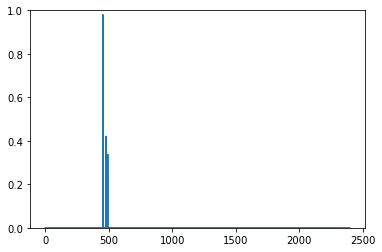

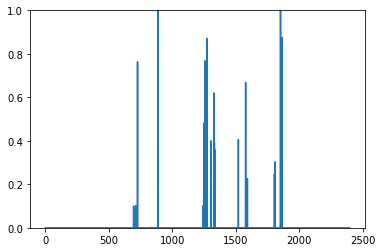

In [78]:
for i in range(len(trigger_list)):
    plt.ylim(0, 1)
    plt.plot(trigger_list[i] * mask_list[i])
    plt.show()